Processing lambda_0001...
Processing lambda_001...
Processing lambda_01...
Processing lambda_09...
Processing lambda_1...
Processing lambda_10...
Processing lambda_100...
Processing lambda_1000...


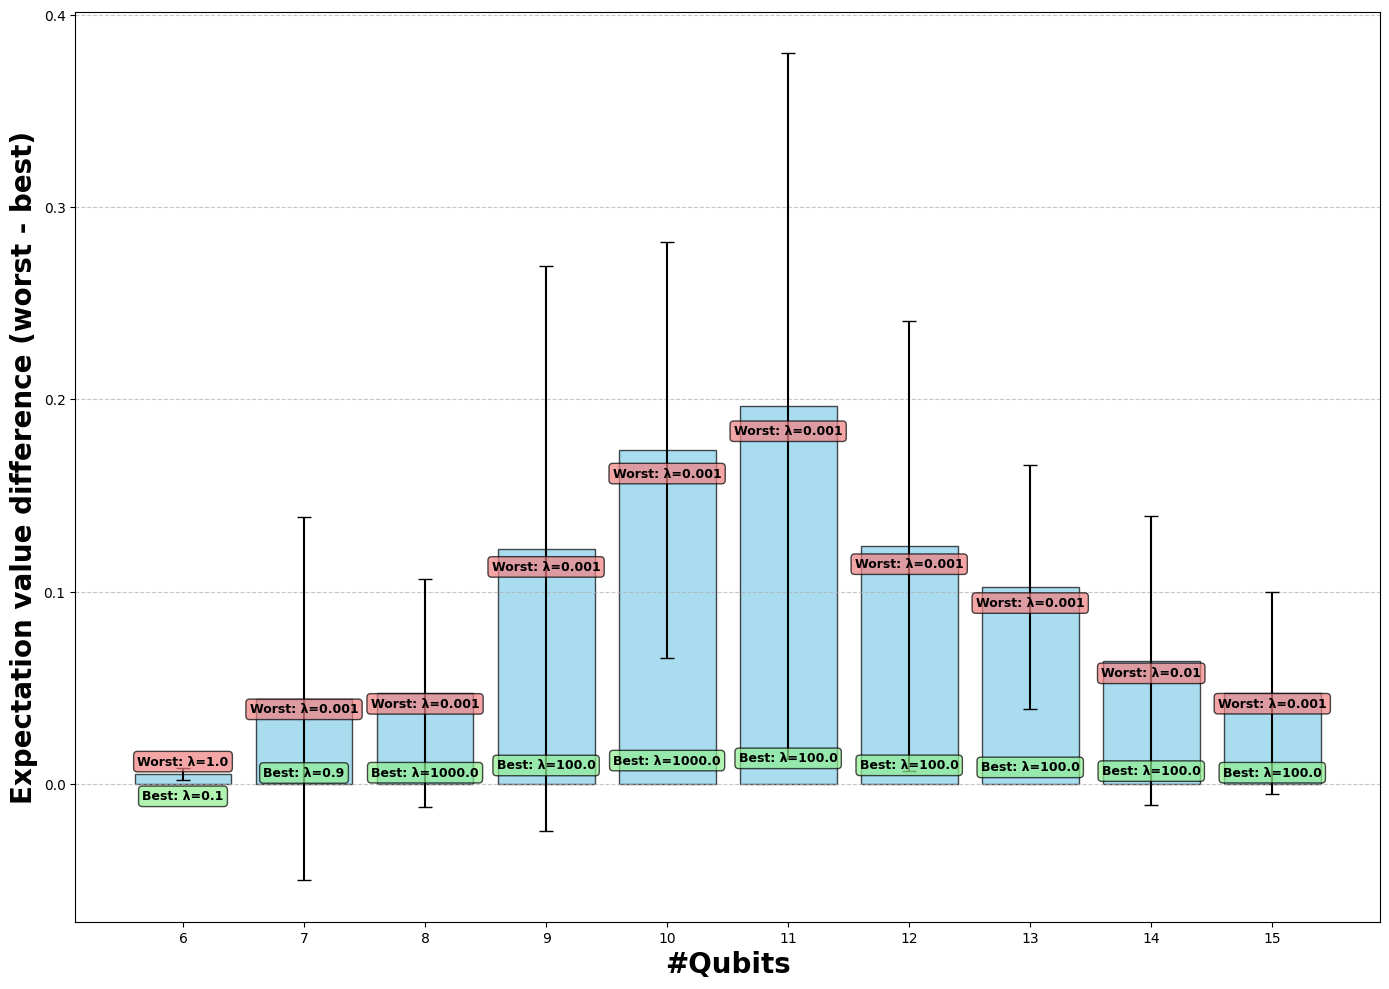


Best lambda values by qubit count:
6 qubits: Lambda=0.01 (used in 2.0/10.0 cases, 20.0%)
7 qubits: Lambda=0.9 (used in 4.0/10.0 cases, 40.0%)
8 qubits: Lambda=1000.0 (used in 4.0/10.0 cases, 40.0%)
9 qubits: Lambda=100.0 (used in 3.0/10.0 cases, 30.0%)
10 qubits: Lambda=1000.0 (used in 3.0/10.0 cases, 30.0%)
11 qubits: Lambda=100.0 (used in 4.0/10.0 cases, 40.0%)
12 qubits: Lambda=100.0 (used in 4.0/10.0 cases, 40.0%)
13 qubits: Lambda=100.0 (used in 4.0/10.0 cases, 40.0%)
14 qubits: Lambda=100.0 (used in 4.0/10.0 cases, 40.0%)
15 qubits: Lambda=100.0 (used in 5.0/10.0 cases, 50.0%)


In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def load_json_files(directory):
    """Load all JSON files in a directory"""
    data = {}
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            try:
                with open(file_path, 'r') as f:
                    file_data = json.load(f)
                    data[filename] = file_data
            except:
                print(f"Error loading {file_path}")
    return data

def extract_expectation_values(data, lambda_val):
    """Extract final expectation values from data with the associated lambda value"""
    results = {}
    for filename, file_data in data.items():
        for case_id, case_data in file_data.items():
            if 'qaoa_solution' in case_data and 'final_expectation_value' in case_data['qaoa_solution']:
                if case_id not in results:
                    results[case_id] = {
                        'lambda': lambda_val,
                        'expectation': case_data['qaoa_solution']['final_expectation_value'],
                        'filename': filename,
                        'hyperparams': case_data.get('hyperparams', {})
                    }
                else:
                    # If we have multiple files for the same case_id, take the best one
                    if case_data['qaoa_solution']['final_expectation_value'] < results[case_id]['expectation']:
                        results[case_id]['expectation'] = case_data['qaoa_solution']['final_expectation_value']
                        results[case_id]['filename'] = filename
                        results[case_id]['hyperparams'] = case_data.get('hyperparams', {})
    return results

# Create a dictionary to hold all lambda folders
lambda_dirs = {
    0.001: "lambda_0001",
    0.01: "lambda_001",
    0.1: "lambda_01",
    0.9: "lambda_09",
    1.0: "lambda_1",
    10.0: "lambda_10",
    100.0: "lambda_100",
    1000.0: "lambda_1000"
}

# Base directory where lambda folders are located
base_dir = "../results/cmaes_hubo_results/"

# Create a dictionary to store best results for each case across all lambda values
best_results = {}

# New: Store all lambda results for each case to analyze min-max differences
all_lambda_results = {}

# Collect data from all lambda directories
for lambda_val, lambda_dir in lambda_dirs.items():
    directory = os.path.join(base_dir, lambda_dir)
    if os.path.exists(directory):
        print(f"Processing {lambda_dir}...")
        lambda_data = load_json_files(directory)
        case_results = extract_expectation_values(lambda_data, lambda_val)
        
        # Update best_results with better values from this lambda
        for case_id, result in case_results.items():
            if case_id not in best_results or result['expectation'] < best_results[case_id]['expectation']:
                best_results[case_id] = result
                
            # Store all lambda results for min-max analysis
            if case_id not in all_lambda_results:
                all_lambda_results[case_id] = {}
            all_lambda_results[case_id][lambda_val] = result['expectation']
    else:
        print(f"Directory not found: {directory}")

# Convert to DataFrame for easier analysis
data_rows = []
for case_id, result in best_results.items():
    data_row = {
        'case_id': int(case_id),
        'best_lambda': result['lambda'],
        'expectation_value': result['expectation'],
        'filename': result['filename']
    }
    
    # Extract qubit count if available
    if 'n_qubits' in result.get('hyperparams', {}):
        data_row['qubits'] = result['hyperparams']['n_qubits']
    
    data_rows.append(data_row)

df = pd.DataFrame(data_rows)

# Sort by case_id for easier reading
df = df.sort_values('case_id')

# New: Calculate lambda impact for each case
lambda_impact_rows = []
for case_id, lambda_results in all_lambda_results.items():
    if len(lambda_results) > 1:  # Only include cases with multiple lambda results
        # Find best and worst lambdas
        best_lambda = min(lambda_results.items(), key=lambda x: x[1])[0]
        worst_lambda = max(lambda_results.items(), key=lambda x: x[1])[0]
        best_value = lambda_results[best_lambda]
        worst_value = lambda_results[worst_lambda]
        diff = worst_value - best_value
        
        # Get qubit count if available
        qubits = None
        if case_id in best_results and 'hyperparams' in best_results[case_id]:
            if 'n_qubits' in best_results[case_id]['hyperparams']:
                qubits = best_results[case_id]['hyperparams']['n_qubits']
        
        lambda_impact_rows.append({
            'case_id': int(case_id),
            'qubits': qubits,
            'best_lambda': best_lambda,
            'worst_lambda': worst_lambda,
            'best_value': best_value,
            'worst_value': worst_value,
            'diff': diff,
            'lambda_count': len(lambda_results)
        })

lambda_impact_df = pd.DataFrame(lambda_impact_rows)
def create_lambda_impact_plot(lambda_impact_df):
    """
    Create a single comprehensive plot showing lambda impact on expectation values
    
    Parameters:
    lambda_impact_df (DataFrame): DataFrame with lambda impact analysis data
    """
    # Skip if no data
    if lambda_impact_df.empty:
        print("No lambda impact data available for analysis.")
        return
    
    # Create a single comprehensive figure
    plt.figure(figsize=(14, 10))
    
    # Use qubit count for x-axis
    qubits = np.array(sorted(lambda_impact_df['qubits'].unique()))
    
    # Group by qubit count
    qubit_groups = lambda_impact_df.groupby('qubits')
    
    # Calculate statistics for each qubit count
    means = []
    stds = []
    best_lambdas = []
    worst_lambdas = []
    
    for q in qubits:
        group = qubit_groups.get_group(q) if q in qubit_groups.groups else pd.DataFrame()
        means.append(group['diff'].mean() if not group.empty else 0)
        stds.append(group['diff'].std() if len(group) > 1 else 0)
        
        # Get most common best and worst lambda values
        if not group.empty:
            best = group['best_lambda'].value_counts().idxmax()
            worst = group['worst_lambda'].value_counts().idxmax()
            best_lambdas.append(best)
            worst_lambdas.append(worst)
        else:
            best_lambdas.append(None)
            worst_lambdas.append(None)
    
    # Plot the mean differences as a bar chart
    ax = plt.gca()
    bars = ax.bar(qubits, means, yerr=stds, capsize=5, 
            color='skyblue', edgecolor='black', alpha=0.7)
    
    # Add lambda labels directly on the plot
    for i, (q, mean, best_lambda, worst_lambda) in enumerate(zip(qubits, means, best_lambdas, worst_lambdas)):
        if best_lambda is not None and worst_lambda is not None and mean > 0:
            # Add best lambda label at bottom of bar
            if int(q) != 6:
                ax.text(q, mean * 0.05, f'Best: λ={best_lambda}', 
                   ha='center', va='bottom', fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))
            else:
                ax.text(q, -mean * 2, f'Best: λ={best_lambda}', 
                   ha='center', va='bottom', fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))
            
            if int(q) != 6:
                ax.text(q, mean * 0.95, f'Worst: λ={worst_lambda}', 
                   ha='center', va='top', fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral', alpha=0.7))
            else:
                ax.text(q, mean * 3, f'Worst: λ={worst_lambda}', 
                   ha='center', va='top', fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral', alpha=0.7))
    
    # Add horizontal grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    # Add annotations explaining the bar elements
    #plt.figtext(0.5, 0.01, 
    #            "Bar height: Mean difference between worst and best lambda results\n"
    #            "Error bars: Standard deviation of differences\n"
    #            "Green labels: Lambda value that typically gives best (lowest) expectation value\n"
    #            "Red labels: Lambda value that typically gives worst (highest) expectation value",
    #            ha='center', fontsize=11, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Add detailed summary statistics
    #stats_text = (
    #    f"Total cases: {len(lambda_impact_df)}\n"
    #    f"Avg. difference: {lambda_impact_df['diff'].mean():.5f}\n"
    #    f"Max difference: {lambda_impact_df['diff'].max():.5f}\n"
    #    f"Cases with multiple lambdas: {len(lambda_impact_df)}"
    #)
    #plt.figtext(0.01, 0.97, stats_text, 
    #           fontsize=10, va='top', 
    #           bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Set titles and labels
    #plt.title('Impact of Lambda Choice on QAOA Expectation Values', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('#Qubits', fontsize=20, fontweight='bold')
    plt.ylabel('Expectation value difference (worst - best)', fontsize=20, fontweight='bold')
    
    # Set x-ticks to be integer qubit counts
    plt.xticks(qubits)
    
    plt.tight_layout()
    plt.savefig('lambda_impact_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return lambda_impact_df

# Generate the combined visualization
impact_df = create_lambda_impact_plot(lambda_impact_df)

# Print summary of best lambdas by qubit count
print("\nBest lambda values by qubit count:")
qubit_lambda = df.groupby('qubits')['best_lambda'].value_counts().unstack().fillna(0)
for qubit, row in qubit_lambda.iterrows():
    best_lambda = row.idxmax()
    count = row.max()
    total = row.sum()
    print(f"{qubit} qubits: Lambda={best_lambda} (used in {count}/{total} cases, {count/total*100:.1f}%)")


Analyzing Lambda Impact on Expectation Values by Case:

Top 10 Cases Most Affected by Lambda Choice:
 case_id  qubits  best_lambda  worst_lambda   min_exp   max_exp     diff       cv
      75      11        100.0         0.001 -0.520927 -0.046201 0.474725 0.367983
      70      11        100.0         0.001 -0.411791 -0.003820 0.407972 0.547344
      37       9       1000.0         0.001 -0.386718 -0.000681 0.386037 0.682348
      76      11       1000.0         0.010 -0.379524 -0.000714 0.378810 0.868452
      36       9        100.0         0.001 -0.320380 -0.006410 0.313970 0.497365
      87       7       1000.0         0.001 -0.583462 -0.273006 0.310456 0.188883
      71      11        100.0         0.010 -0.311947 -0.019571 0.292376 0.430888
       6      10       1000.0         0.001 -0.298887 -0.016513 0.282374 0.408354
      30       9        100.0         0.010 -0.371168 -0.097125 0.274043 0.291192
       8      10       1000.0         0.001 -0.354326 -0.081468 0.272859 0.287

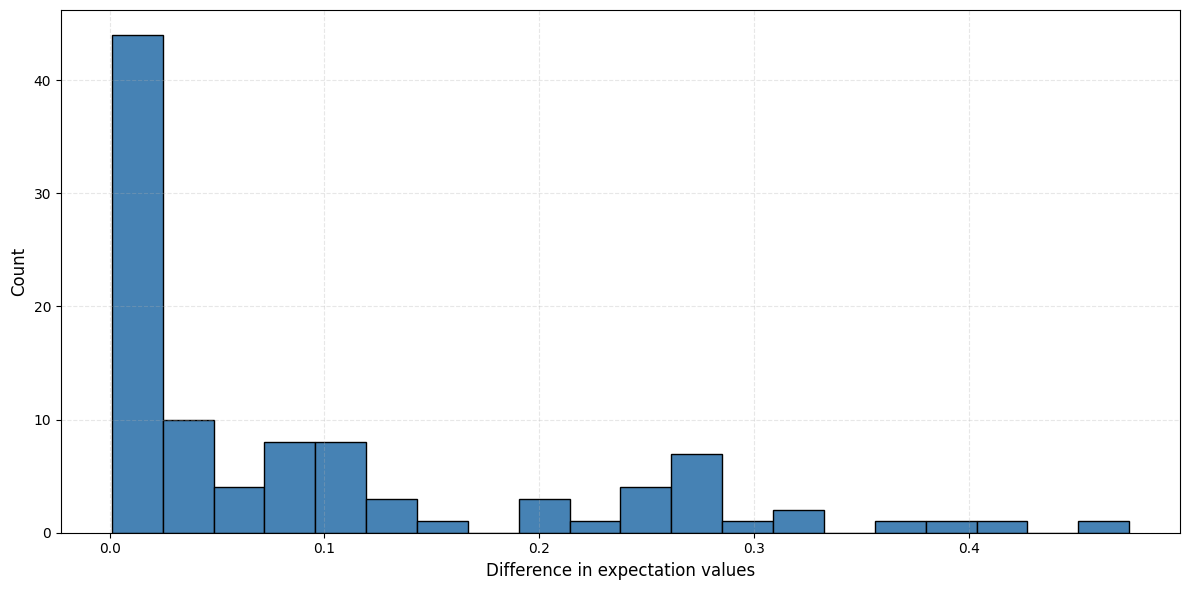

In [2]:
# 6. Analyze impact of lambda on expectation values for each case
print("\nAnalyzing Lambda Impact on Expectation Values by Case:")

# First, we need to collect all lambda results for each case
all_lambda_results = {}

# Go through all lambda directories again
for lambda_val, lambda_dir in lambda_dirs.items():
    directory = os.path.join(base_dir, lambda_dir)
    if os.path.exists(directory):
        lambda_data = load_json_files(directory)
        case_results = extract_expectation_values(lambda_data, lambda_val)
        
        # Store all results by case_id and lambda_val
        for case_id, result in case_results.items():
            if case_id not in all_lambda_results:
                all_lambda_results[case_id] = {}
            all_lambda_results[case_id][lambda_val] = result['expectation']

# Convert to DataFrame for analysis
lambda_impact_rows = []
for case_id, lambda_results in all_lambda_results.items():
    if len(lambda_results) > 1:  # Only include cases with multiple lambda results
        # Calculate the range of expectation values for this case
        min_exp = min(lambda_results.values())
        max_exp = max(lambda_results.values())
        diff = max_exp - min_exp
        best_lambda = min(lambda_results.items(), key=lambda x: x[1])[0]
        worst_lambda = max(lambda_results.items(), key=lambda x: x[1])[0]
        
        # Calculate average and standard deviation
        avg_exp = np.mean(list(lambda_results.values()))
        std_exp = np.std(list(lambda_results.values()))
        
        # Calculate coefficient of variation (normalized standard deviation)
        # Since expectation values are negative, we use absolute values
        cv = std_exp / abs(avg_exp) if avg_exp != 0 else 0
        
        # Get qubit count if available
        qubits = df[df['case_id'] == int(case_id)]['qubits'].values[0] if int(case_id) in df['case_id'].values else None
        
        lambda_impact_rows.append({
            'case_id': int(case_id),
            'qubits': qubits,
            'best_lambda': best_lambda,
            'worst_lambda': worst_lambda,
            'min_exp': min_exp,
            'max_exp': max_exp,
            'avg_exp': avg_exp,
            'std_exp': std_exp,
            'diff': diff,
            'cv': cv,  # Coefficient of variation
            'lambda_values': len(lambda_results)
        })

lambda_impact_df = pd.DataFrame(lambda_impact_rows)

# Sort by the difference to see which cases are most affected by lambda choice
lambda_impact_df = lambda_impact_df.sort_values('diff', ascending=False)

# Display top 10 cases most affected by lambda
print("\nTop 10 Cases Most Affected by Lambda Choice:")
top_cases = lambda_impact_df.head(10)[['case_id', 'qubits', 'best_lambda', 'worst_lambda', 'min_exp', 'max_exp', 'diff', 'cv']]
print(top_cases.to_string(index=False))

# Visualize the impact of lambda on expectation values

# 1. Distribution of expectation value differences
plt.figure(figsize=(12, 6))
plt.hist(lambda_impact_df['diff'], bins=20, color='steelblue', edgecolor='black')
#plt.title('Distribution of expectation value differences (max - min) for 100 problems with QAOA', fontsize=14, fontweight='bold')
plt.xlabel('Difference in expectation values', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()